In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import copy
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models import resnet18, ResNet18_Weights, convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.models.resnet import ResNet
from torchvision.models.convnext import ConvNeXt
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path

from classifiers.models import CNN_MNIST
from stylegan2_ada_pytorch.training.dataset import ImageFolderDataset
from utils import EasyDict


torch.manual_seed(0)
np.random.seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

path_results = Path.cwd().parent / 'results'

In [2]:
config = EasyDict()
config.dataset = 'mnist_stylegan2_blur_noise_maxSeverity3_proba50'
config.task = 'trueClassProba' # trueClassProba binaryClassif
config.model = 'ResNet_pretrained' # CNN CNN_pretrained ConvNeXt ConvNeXt_pretrained ResNet ResNet_pretrained


## Load data and classifier

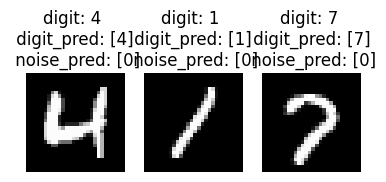

In [3]:
# LOAD DATA
def load_data(dataset, device):
    path_data = Path.cwd().parent / 'data/MNIST' / f'{dataset}.zip'
    ds_original = ImageFolderDataset(path_data, use_labels=True)

    # LOAD CLASSIFIER

    # predict digits
    classifier_digits = CNN_MNIST(output_dim=10).to(device)
    # classifier_digits.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_MNIST_weights_20220411_0826.pth', map_location=device)) # Confiance
    classifier_digits.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_MNIST_weights_20220210_1601.pth', map_location=device))
    # classifier_digits.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_mnist_stylegan2_blur_noise_maxSeverity3_proba50_20220510_1124.pth', map_location=device))
    classifier_digits.eval()

    # predict noise
    classifier_noise = CNN_MNIST(output_dim=6).to(device)
    # classifier_noise.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_noise_MNIST_weights_20220411_0841.pth', map_location=device)) # Confiance
    classifier_noise.load_state_dict(torch.load(path_results / 'classifiers' / 'CNN_MNIST_noise_weights_20220210_1728.pth', map_location=device))
    classifier_noise.eval()

    # TEST
    n_images = 3
    plt.figure(figsize=(15, 5))
    for i in range(min(n_images, 5)):

        idx = np.random.randint(len(ds_original))
        img = ds_original[idx][0]
        digit = ds_original[idx][1].argmax()

        img = torch.tensor(img, device=device).unsqueeze(0)
        img = (img / 255)[:, :, 2:30, 2:30]

        digit_pred = classifier_digits(img).argmax(dim=1).cpu()
        noise_pred = classifier_noise(img).argmax(dim=1).cpu()

        plt.subplot(1, 10, i+1)
        plt.imshow(img.cpu().squeeze(), cmap='gray')
        plt.title(f'digit: {digit} \n digit_pred: {digit_pred.numpy()} \n noise_pred: {noise_pred.numpy()}')
        plt.axis('off')

    return ds_original, classifier_digits, classifier_noise

## Create dataset with labels wellclassified (1) or misclassified (0)

In [4]:
def create_datasets(task, ds_original, classifier_digits, batch_size=128, train_split=0.8):

    if config.task == 'binaryClassif':

        # DATASETS

        digit_pred = 99*torch.ones((len(ds_original)), dtype=int)
        for idx, (x, y) in enumerate(DataLoader(ds_original, batch_size=256)):
            x = (x / 255)[:, :, 2:30, 2:30].to(device)
            digit_pred[idx*256:(idx+1)*256] = classifier_digits(x).argmax(dim=1).cpu()

        idx_positive = np.nonzero(digit_pred.numpy() == ds_original._raw_labels)[0]
        idx_negative = np.nonzero(digit_pred.numpy() != ds_original._raw_labels)[0]


        # ds_positive = Subset(ds_original, idx_positive)
        # ds_negative = Subset(ds_original, idx_negative)

        # for x, y in DataLoader(ds_positive, batch_size=256):
        #     x = (x / 255)[:, :, 2:30, 2:30].to(device)
        #     y_pred = classifier_digits(x).argmax(dim=1).cpu()
        #     y = y.argmax(dim=1).cpu()
        #     assert all(y == y_pred), 'should be well classified'

        # for x, y in DataLoader(ds_negative, batch_size=256): # WEIRD: logits change slightly with different batch sizes (even with model.eval())
        #     x = (x / 255)[:, :, 2:30, 2:30].to(device)
        #     y_pred = classifier_digits(x).argmax(dim=1).cpu()
        #     y = y.argmax(dim=1).cpu()
        #     assert all(y != y_pred), 'should be mis classified'

        # print('checked that subsets are classified as they should be')

        ds_correctness = copy.deepcopy(ds_original)
        ds_correctness[0] # somehow need to do this for next lines to work
        ds_correctness._label_shape = [2] # 2 classes: correct or incorrect
        ds_correctness._raw_labels[idx_positive] = 1
        ds_correctness._raw_labels[idx_negative] = 0

        print('{:.2f}% of images are correctly classified'.format(100*len(idx_positive)/len(ds_original)))
        print('{:.2f}% of images are incorrectly classified'.format(100*len(idx_negative)/len(ds_original)))

        
    elif config.task == 'trueClassProba':
        tcp = 99*torch.ones((len(ds_original)))
        for idx, (x, y) in enumerate(DataLoader(ds_original, batch_size=256)):
            x = (x / 255)[:, :, 2:30, 2:30].to(device)
            with torch.no_grad():
                tcp[idx*256:(idx+1)*256] = nn.functional.softmax(classifier_digits(x), dim=1)[y.bool()].cpu()

        idx_positive = np.nonzero(tcp.numpy() > 0.9)[0] # indices with high score
        idx_negative = np.nonzero(tcp.numpy() <= 0.9)[0] # indices with low score

        ds_correctness = copy.deepcopy(ds_original)
        ds_correctness[0] # somehow need to do this for next lines to work
        ds_correctness._label_shape = [1]
        ds_correctness._raw_labels = tcp.numpy()

        print('{:.2f}% of images have high TCP'.format(100*len(idx_positive)/len(ds_original)))
        print('{:.2f}% of images have low TCP'.format(100*len(idx_negative)/len(ds_original)))


    # DATALOADERS

    np.random.shuffle(idx_negative)
    np.random.shuffle(idx_positive)
    idx_negative_train, idx_negative_test = idx_negative[:int(train_split*len(idx_negative))], idx_negative[int(train_split*len(idx_negative)):]
    idx_positive_train, idx_positive_test = idx_positive[:int(train_split*len(idx_positive))], idx_positive[int(train_split*len(idx_positive)):]
    idx_train = np.concatenate((idx_positive_train, idx_negative_train))
    idx_test = np.concatenate((idx_positive_test, idx_negative_test))
    ds_correctness_train = Subset(ds_correctness, idx_train)
    ds_correctness_test = Subset(ds_correctness, idx_test)

    train_dataloader = DataLoader(ds_correctness_train, batch_size=batch_size, shuffle=True) # shuffle NECESSARY!!! because positive and negative are concatenated
    test_dataloader = DataLoader(ds_correctness_test, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader

77.66% of images have high TCP
22.34% of images have low TCP


## Show examples of well-classified (top) and misclassified (bottom)

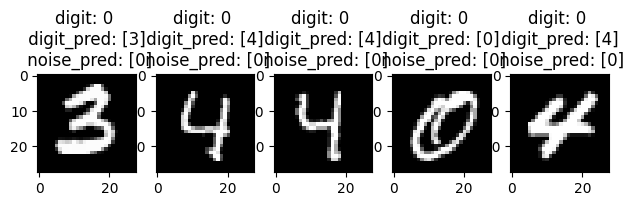

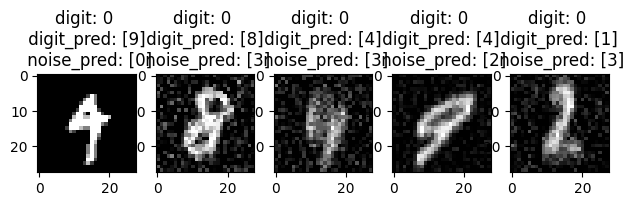

In [5]:
# # if config.task == 'binaryClassif':
# for idx_list in [idx_positive, idx_negative]:
#     n_images = 8
#     plt.figure(figsize=(15, 5))
#     for i in range(min(n_images, 5)):

#         idx = np.random.choice(idx_list)
#         img = ds_correctness[idx][0]
#         digit = ds_correctness[idx][1].argmax()

#         img = torch.tensor(img, device=device).unsqueeze(0)
#         img = (img / 255)[:, :, 2:30, 2:30]

#         digit_pred = classifier_digits(img).argmax(dim=1).cpu()
#         noise_pred = classifier_noise(img).argmax(dim=1).cpu()

#         plt.subplot(1, 10, i+1)
#         plt.imshow(img.cpu().squeeze(), cmap='gray')
#         plt.title(f'digit: {digit} \n digit_pred: {digit_pred.numpy()} \n noise_pred: {noise_pred.numpy()}')

# Define module

In [6]:
class Model(pl.LightningModule):

    def __init__(self, model_name, loss_name, classifier_digits):
        super().__init__()

        if loss_name == 'CrossEntropyLoss':
            output_dim = 2
            class_weights = torch.tensor([len(idx_positive)/len(idx_negative), 1], dtype=torch.float)
            self.loss_function = nn.CrossEntropyLoss(weight=class_weights)
        elif loss_name == 'BCEWithLogitsLoss':
            output_dim = 1
            self.loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(len(idx_positive)/len(idx_negative)))
        elif loss_name == 'MSELoss':
            output_dim = 1
            self.loss_function = nn.MSELoss()

        if model_name == 'ResNet':
            weights = ResNet18_Weights.DEFAULT
            self.preprocess = weights.transforms()
            self.model = resnet18()
            self.model.fc = nn.Linear(512, output_dim, device=device) # replace last layer
        elif model_name == 'ResNet_pretrained':
            weights = ResNet18_Weights.DEFAULT
            self.preprocess = weights.transforms()
            self.model = resnet18(weights=weights)
            self.model.fc = nn.Linear(512, output_dim, device=device) # replace last layer
        elif model_name == 'ConvNeXt':
            weights = ConvNeXt_Tiny_Weights.DEFAULT
            self.preprocess = weights.transforms()
            self.model = convnext_tiny()
            self.model.classifier[2] = nn.Linear(768, output_dim) # replace last layer
        elif model_name == 'ConvNeXt_pretrained':
            weights = ConvNeXt_Tiny_Weights.DEFAULT
            self.preprocess = weights.transforms()
            self.model = convnext_tiny(weights=weights)
            self.model.classifier[2] = nn.Linear(768, output_dim) # replace last layer

        elif model_name == 'CNN':
            self.model = CNN_MNIST(1, output_dim)
        elif model_name == 'CNN_pretrained':
            self.model = copy.deepcopy(classifier_digits)
            self.model.net[9] = nn.Linear(128, output_dim, device=device) # replace last layer
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        if isinstance(self.model, ResNet) or isinstance(self.model, ConvNeXt):
            x = self.preprocess(x.expand(-1, 3, -1, -1))
        elif isinstance(self.model, CNN_MNIST):
            x = (x / 255.)[:, :, 2:30, 2:30]
        return self.model(x)

    def _compute_loss(self, batch, mode):
        x, y = batch
        if config.task == 'binaryClassif':
            y = y.argmax(1)
        if isinstance(self.loss_function, nn.BCEWithLogitsLoss) or isinstance(self.loss_function, nn.MSELoss):
            y = y.unsqueeze(1).float()
        y_hat = self(x)
        loss = self.loss_function(y_hat, y)
        if isinstance(self.loss_function, nn.BCEWithLogitsLoss):
            acc = (torch.sigmoid(y_hat).round() == y).sum() / y.shape[0]
        elif isinstance(self.loss_function, nn.CrossEntropyLoss):
            acc = (y_hat.argmax(dim=1) == y).sum() / y.shape[0]
        self.log(f"{mode}_loss", loss)
        if 'acc' in locals(): self.log(f"{mode}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._compute_loss(batch, mode='train')
        return loss

    def validation_step(self, batch, batch_idx):
        self._compute_loss(batch, mode='val')


In [10]:
def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)

os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp')
[int(x.split()[2]) for x in open('tmp', 'r').readlines()]

[5515, 11359, 16507, 8]

In [7]:
if config.task == 'binaryClassif':
    # loss_name = 'CrossEntropyLoss'
    loss_name = 'BCEWithLogitsLoss'
elif config.task == 'trueClassProba':
    loss_name = 'MSELoss'


print(f'{config.model } - {loss_name}')

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logger = TensorBoardLogger(save_dir=Path.cwd().parent / 'lightning_logs', 
                        name='learn_classifier_correctness', version=f'{config.model}_{loss_name}_{timestamp}')
trainer = pl.Trainer(max_epochs=30, accelerator="gpu", devices=1, logger=logger)
model = Model(config.model, loss_name)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)


ResNet_pretrained - MSELoss


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type                | Params
------------------------------------------------------
0 | loss_function | MSELoss             | 0     
1 | preprocess    | ImageClassification | 0     
2 | model         | ResNet              | 11.2 M
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/d/alecoz/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/d/alecoz/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/d/alecoz/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
